In [1]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import math
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import tensorflow as tf
from scipy.spatial import Delaunay
from scipy.interpolate import griddata
import pandas as pd

image_positive = '/mnt/d/datasets/INBREAST/inbreast/images/50997134_Right_CC_acr_1_birads_2.png'
crop_size = [224, 224]

In [2]:
def crop_black_part(image_array):
    # Cropping every column that doesn't contain tissue
    not_dark = np.where(image_array != 0, 1, 0)
    tissue_distrib_x = np.sum(not_dark, axis=0) / not_dark.shape[0]
    tissue_distri_y = np.sum(not_dark, axis=1) / not_dark.shape[1]
    is_tissue_x = np.where(tissue_distrib_x > 0.1, 1, 0)
    is_tissue_y = np.where(tissue_distri_y > 0.1, 1, 0)

    first_tissue_x = np.where(is_tissue_x == 1)[0][0]
    last_tissue_x = np.where(is_tissue_x == 1)[-1][-1]
    first_tissue_y = np.where(is_tissue_y == 1)[0][0]
    last_tissue_y = np.where(is_tissue_y == 1)[-1][-1]

    return image_array[first_tissue_y:last_tissue_y,first_tissue_x:last_tissue_x]

In [7]:
model = tf.keras.models.load_model('/mnt/d/datasets/INBREAST/results/resnet50_with_batch_norm_extendedV3.keras')

In [3]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

In [5]:
step = 50

In [13]:
image_count = 0

crops_y = 0
processed_y = 0

# Crop picture to equal parts
image = Image.open(image_positive)    
image_array = np.array(image)        

crop_array = crop_black_part(image_array) 

width = math.ceil(crop_array.shape[1] / step)
height = math.ceil(crop_array.shape[0] / step)

heat = np.zeros([height, width])

while processed_y + crop_size[0] < crop_array.shape[0]:       
    crops_x = 0
    processed_x = 0
    crop = True
    
    while crop:     
        if processed_x + crop_size[1] > crop_array.shape[1]:
            processed_x = crop_array.shape[1] - crop_size[1] - 1
            crop = False
    
        grid_array = crop_array[processed_y : processed_y + crop_size[0], processed_x : processed_x + crop_size[1]]
        
        im = Image.fromarray(grid_array)
        im = im.save(f'/mnt/d/datasets/INBREAST/heatmap/positive/{image_count}.png', mode='L')
        
        img = tf.keras.preprocessing.image.load_img(f'/mnt/d/datasets/INBREAST/heatmap/positive/{image_count}.png', target_size=(224,224))
        
        img_array = tf.keras.preprocessing.image.img_to_array(img)
        preped_array = tf.keras.applications.resnet_v2.preprocess_input(img_array)
        preped_array = np.expand_dims(preped_array, axis=0)
        
        heat[crops_y, crops_x] = model(preped_array)
        
        image_count += 1
        
        processed_x += step
        crops_x += 1 
        
    processed_y += step
    crops_y += 1
    
    if crops_y % 10 == 0:
        percent = (crops_y / height) * 100
        print(f"{percent}% done")

16.666666666666664% done
33.33333333333333% done
50.0% done
66.66666666666666% done
83.33333333333334% done


In [14]:
Xi = []
Yi = []
Zi = []

for y, row in enumerate(heat):
    for x, num in enumerate(row):
        Xi.append(x * step + step / 2)
        Yi.append(y * step + step / 2)
        if num < 0.5:
            num = 0
        Zi.append(num)


In [15]:
Pi = np.array([Xi, Yi]).transpose()
tri = Delaunay(Pi)

In [16]:
N = len(Xi)
x = np.linspace(0., np.max(Xi), N)
y = np.linspace(0., np.max(Yi), N)
X, Y = np.meshgrid(x, y)
P = np.array([X.flatten(), Y.flatten() ]).transpose()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


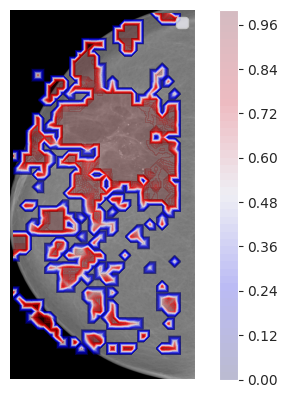

In [18]:
Z_linear = griddata(Pi, Zi, P, method = "linear").reshape([len(Yi), N])
plt.imshow(crop_array, cmap='gray')
plt.contourf(X, Y, Z_linear, 50, cmap='seismic', alpha=0.2)
plt.colorbar()
plt.legend()
plt.axis('off')
plt.savefig('/mnt/d/datasets/INBREAST/results/heatmap.png')
plt.show()

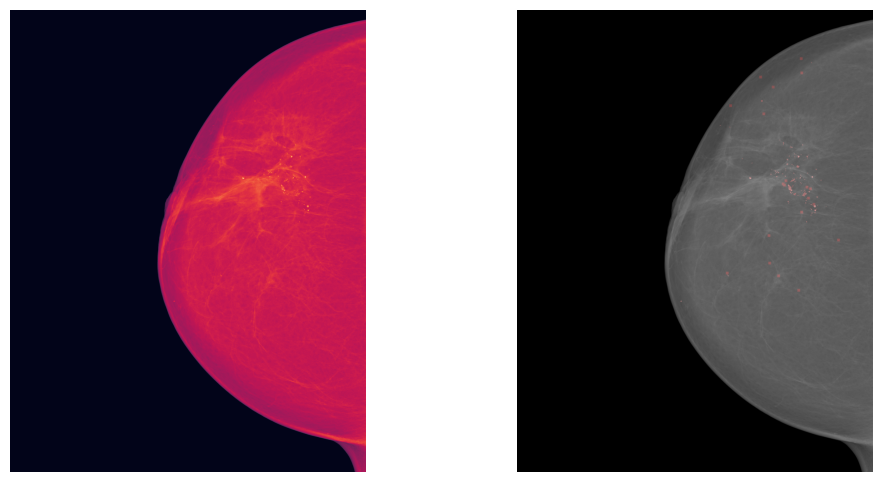

In [20]:
image_to_mask = '/mnt/d/datasets/INBREAST/inbreast/images/50997134_Right_CC_acr_1_birads_2.png'
positive_anon = image_to_mask.split('/')[-1].split('_')[0]
image = Image.open(image_to_mask)
image_array = np.array(image)
positive_mask = np.zeros([image_array.shape[0], image_array.shape[1]])

for file in os.listdir('/mnt/d/datasets/INBREAST/inbreast/masks'):
    mask_anon = file.split('_')[0]
    
    if mask_anon == positive_anon:
        if '.png' in file:
            mask = Image.open(os.path.join('/mnt/d/datasets/INBREAST/inbreast/masks', file))
            mask_array = np.array(mask)
            positive_mask = np.where(mask_array, 1, positive_mask)
        elif '.csv' in file:
            grains = np.genfromtxt(os.path.join('/mnt/d/datasets/INBREAST/inbreast/masks', file), delimiter=',')
            
            for grain in grains:
                y = int(image_array.shape[0] * grain[0])
                x = int(image_array.shape[1] * grain[1])
                
                positive_mask[y - 10:y + 10, x - 10:x + 10] = 1
 
masked_image = image.convert('RGB')
masked_image_array = np.array(masked_image)
positive_mask = np.where(positive_mask > 0, True, False)
masked_image_array[positive_mask] += np.array([50, 0, 0], dtype=np.uint8)

Image.fromarray(masked_image_array).save('/mnt/d/datasets/INBREAST/results/mask.png')
               
# Display the original image and the masked image
fig, ax = plt.subplots(1, 2, figsize=(12, 6))   

ax[0].imshow(image_array)
ax[0].axis('off')

ax[1].imshow(masked_image_array)
ax[1].axis('off')

plt.show()

In [39]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              